## Simulation of Prices of Coupon-Bearing Bonds using CIR

In [14]:
import numpy as np
import pandas as pd
import edhec_risk_kit as erk
%load_ext autoreload
%autoreload 2 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In general, discount rates are not constant. However, we've seen that they can be modelled by using CIR model.

In [15]:
erk.bond_price(5,100,0.05,12,0.03)

109.2753929478012

If we have a look at the bond price using the first interest rate of some scenarios:

In [16]:
rates, zc_prices = erk.cir(10,500,b=0.03,r_0=0.03) 

erk.bond_price(5,100,0.05,12,rates.iloc[0][[1,2,3]]) #checking bond price for the first rate of 3 scenarios

ValueError: operands could not be broadcast together with shapes (3,) (60,) 

Of course, the first interest rate is the same for all scenarios, so we obtain the same bond price. However, let's see what happens when we choose the second interest rate:

In [17]:
erk.bond_price(5,100,0.05,12,rates.iloc[1][[1,2,3]]) #checking bond price for the first rate of 3 scenarios

ValueError: operands could not be broadcast together with shapes (3,) (60,) 

In this case, bond prices change because the interest rate in each scenario is different:

In [18]:
rates.iloc[1][[1,2,3]]

1    0.032389
2    0.028440
3    0.030339
Name: 1, dtype: float64

We will now update the bond_price function (it is already updated in the module) in order to consider cases in which the discount rate is not constant. These non-constant rates are assumed to be given in a DataFrame. Otherwise, the function will consider the rate given as constant (0.03 if left as default).

In [36]:
def bond_price(maturity,principal=100,coupon_rate=0.03,coupons_per_year=12,discount_rate=0.03):
    
    """
    Computes the price of a bond that pays regular coupons until maturity, at which
    time the principal and the final coupon is returned.
    If discount_rate is a DataFrame, then this is assumed to be the rate on each coupon 
    date and the bond value is computed over time.
    """
    
    if isinstance(discount_rate,pd.DataFrame):
        pricing_dates = discount_rate.index
        prices = pd.DataFrame(index=pricing_dates, columns=discount_rate.columns)
        for t in pricing_dates:
            prices.loc[t] = bond_price(maturity-t/coupons_per_year,principal,coupon_rate,
                                       coupons_per_year, discount_rate.loc[t]) #maturity decreases with each loop
        return prices
    
    else: 
        if maturity <=0: return principal + (principal*coupon_rate)/coupons_per_year #single time period
        cash_flows = erk.bond_cash_flows(maturity,principal,coupon_rate,coupons_per_year)
        return erk.pv(cash_flows,discount_rate/coupons_per_year)
    
    
    
    
    
    
    
    
    
    

We will see now how the bond price changes for 5 different scenarios when the discount rate is not constant:

<AxesSubplot:>

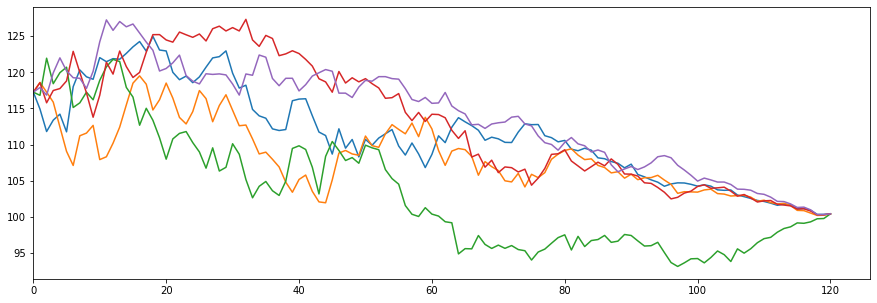

In [37]:
prices = erk.bond_price(10,100,0.05,12,rates[[1,2,3,4,5]])

prices.plot(legend=False, figsize=(15,5),xlim=0)

As you can see, because the discount rate is lower than the coupon rate (0.05 vs 0.03 + GBM), the bond is "always" (unless there is a spectacular discount rate) at a premium. You can see that its prices varies, and it can get lower than the principal (which in this case is 100), but it always ends up at a present value of 100.

Now we can calculate the annualized return of some scenarios. In order to do this, we can use the function "bond_total_return", which returns the monthly bond returns taking into account the dividend payout, and then we can annualize the results:

In [38]:
prices = erk.bond_price(10,100,0.05,12,rates[[1,2,3,4]])

btr = erk.bond_total_return(prices,100,0.05,12)

erk.annualized_rets(btr,12)



1    0.029902
2    0.031157
3    0.033645
4    0.029303
dtype: float64

So the annualized returns fluctuate around 3$\%$

Let's check what happens to the bond prices of a 30-year bond with discount rates up to 10 years. We should expect it to not converge to a value for all scenarios, as the bond has not reached its maturity:

In [39]:
price_10 = erk.bond_price(10,100,0.05,12,rates)
price_30 = erk.bond_price(30,100,0.05,12,rates) 

price_30[[1,2,3]].tail()

,1,2,3
116,160.137,141.637,72.1256
117,164.634,132.282,71.3324
118,172.054,136.423,68.1461
119,175.937,143.115,71.5845
120,179.683,143.621,70.2479


Let's have a look at the stats of a portfolio composed of 10-year and 30-year bonds.

In [41]:
rets_10 = erk.bond_total_return(price_10,100,0.05,12)
rets_30 = erk.bond_total_return(price_30,100,0.05,12)

rets_bonds = 0.6*rets_10 + 0.4*rets_30 #portfolio is weighted like this

In [42]:
mean_rets_bonds = rets_bonds.mean(axis='columns')
erk.summarize_stats(pd.DataFrame(mean_rets_bonds))

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Cornish-Fisher CVaR,Sharpe Ratio
0,0.036455,0.003791,0.448536,3.480563,-0.00135,-0.001005,1.656981


Bear in mind that we have negatives VaR and CVaR, meaning that the worst 5-quantile still gives a positive returns on average (remember that in VaR and CVaR we change the sign of the return, as it is usually negative. This way, we would have positive quantities).

Let's generate some stock returns now:

In [43]:
price_eq = erk.gbm(n_years=10,n_scenarios=500, mu=0.07,sigma=0.15)
rets_eq = price_eq.pct_change().dropna()

And now we mix the stocks and the bond portfolio:

In [44]:
rets = 0.7*rets_eq + 0.3*rets_bonds

rets_mean = rets.mean(axis='columns')
erk.summarize_stats(pd.DataFrame(rets_mean))

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Cornish-Fisher CVaR,Sharpe Ratio
0,0.061898,0.004994,0.394033,3.42802,-0.002877,-0.002506,6.267595


Of course, this is just an example. In the next notebook we will show how to obtain the best weights, our best stock-bond mix for our portfolio